In [114]:
import pandas as pd
import glob
import datetime
import os
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import normalize
import joblib
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE  
import pickle as pkl
np.random.seed(999)

with open('./Folder_name/Xtest.xlsx', 'rb') as f:
    X = pd.read_excel(f)
    print(X.shape)
with open('./Folder_name/Ytest.xlsx', 'rb') as f:
    Y = pd.read_excel(f,squeeze=True)
    print(Y.shape)
    
plt.rcParams['savefig.dpi'] = 150 #图片像素
plt.rcParams['figure.dpi'] = 150 #分辨率
def plot_roc_curve(fpr, tpr, auc, model):
    plt.plot(fpr, tpr, color='orange', label='ROC_'+model)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve, AUC: {:3f}'.format(auc))
    plt.legend()
    plt.axis([0, 1, 0, 1])
    plt.show()

classifier_model = []
classifier_accuracy = []
CM = []
AUC = []
fpr_tpr = []
thre = 0.45
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
with open('./model/RandomForest.pkl','rb') as f:
    rfc = joblib.load(f)
classifier_model.append('RandomForest')
classifier_accuracy.append(rfc.score(X, Y))

y_pred = rfc.predict(X)
prob = rfc.predict_proba(X)[:,1]
auc = roc_auc_score(Y, prob)
CM.append(confusion_matrix(Y,prob>thre))
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(Y, prob)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'RandomForest')

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

prec, rec, tre = precision_recall_curve(Y, prob)
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.savefig('./PR_threshold_ev.png')

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(Y, prob)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(rfc, X, Y)

disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.savefig('PR_curve_ev.png')

from sklearn.tree import DecisionTreeClassifier
with open('./model/DecisionTree.pkl','rb') as f:
    dtc = joblib.load(f)
classifier_model.append('DecisionTree')
classifier_accuracy.append(dtc.score(X, Y))

y_pred = dtc.predict(X)
prob = dtc.predict_proba(X)[:,1]
auc = roc_auc_score(Y, prob)
CM.append(confusion_matrix(Y, y_pred))
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(Y, prob)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, auc, 'DecisionTree')

## Plot AUROC curve

(258, 16)
(258,)


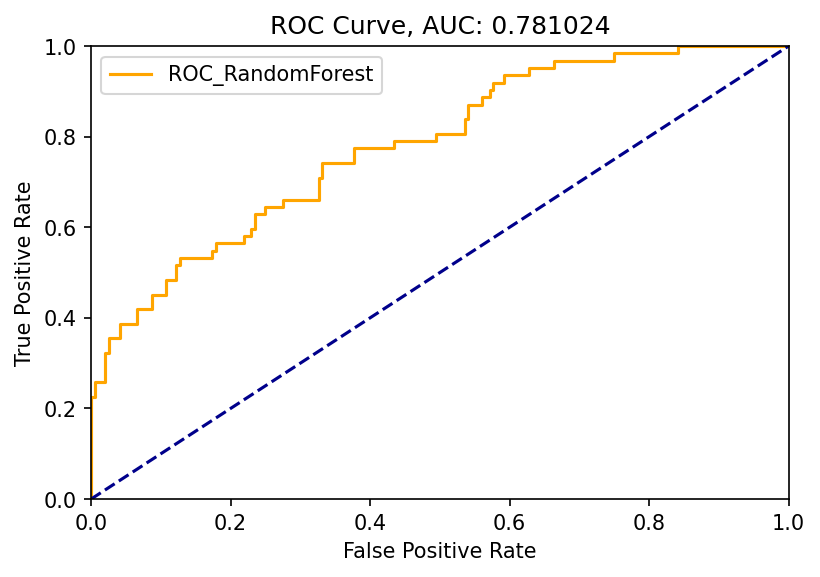

Average precision-recall score: 0.63
Feature ranking:


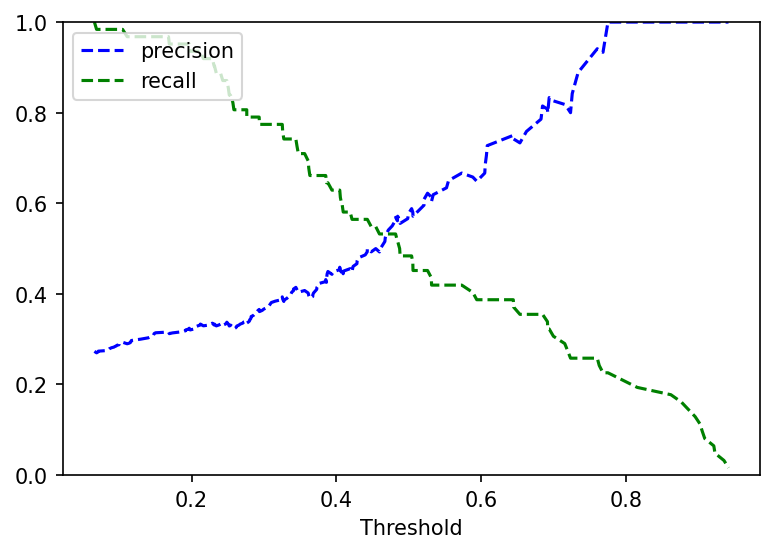

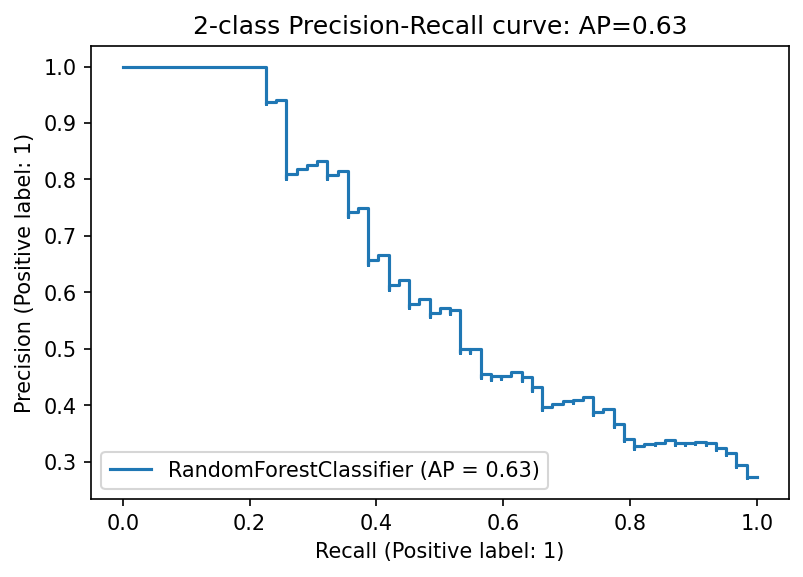

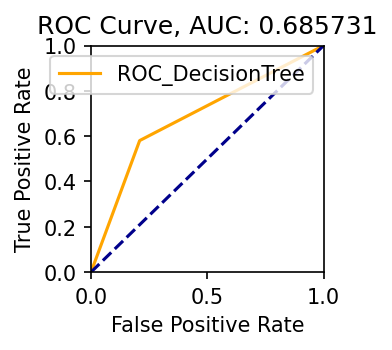

['RandomForest', 'DecisionTree']


<function matplotlib.pyplot.show(close=None, block=None)>

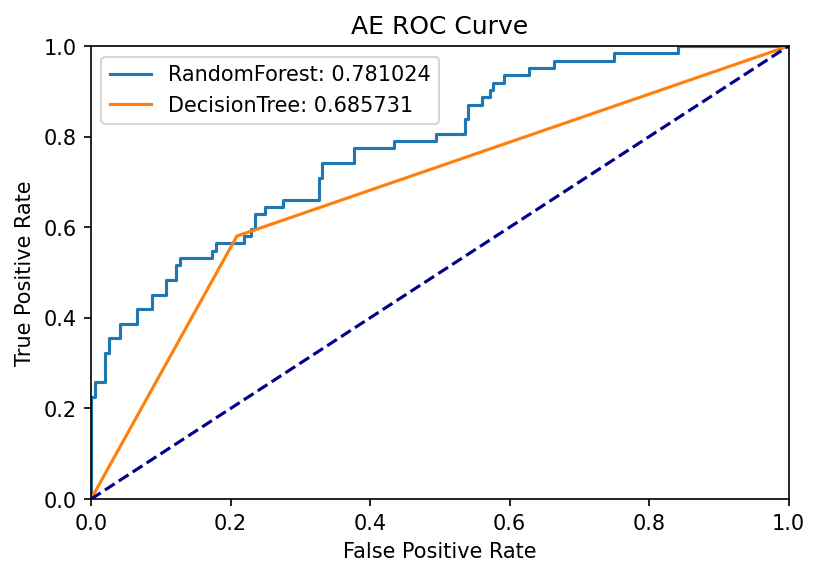

In [114]:
plt.figure()
for idx in range(2):
    fpr, tpr = fpr_tpr[idx][0], fpr_tpr[idx][1]
    plt.plot(fpr, tpr, label=classifier_model[idx] + ': {0:2f}'.format(AUC[idx]))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AE ROC Curve')
plt.legend()
plt.axis([0, 1, 0, 1])
plt.savefig('AE_ev.png')
plt.show

## Export result

In [115]:
result = {}
result = {
    'model':classifier_model,
    'accuracy':classifier_accuracy,
    'confusion matrix':CM,
    'AUROC': AUC
}

result = pd.DataFrame(result).round(3)
result['Specificity'] = result['confusion matrix'].apply(lambda x: x[0,0]/(x[0,0]+x[0,1])).round(3)
result['Sensitivity'] = result['confusion matrix'].apply(lambda x: x[1,1]/(x[1,1]+x[1,0])).round(3)
result['Precision'] = result['confusion matrix'].apply(lambda x: x[1,1]/(x[1,1]+x[0,1])).round(3)
result['F1_score'] = (2 / ((1/result['Sensitivity'])+(1/result['Precision']))).round(3)

print(result)
result.to_excel('reslut_ev.xlsx',index=False)


          model  accuracy       confusion matrix  AUROC  Specificity  \
0  RandomForest     0.795  [[162, 34], [28, 34]]  0.781        0.827   
1  DecisionTree     0.740  [[155, 41], [26, 36]]  0.686        0.791   

   Sensitivity  Precision  F1_score  
0        0.548      0.500     0.523  
1        0.581      0.468     0.518  


## Plot confusion matrix

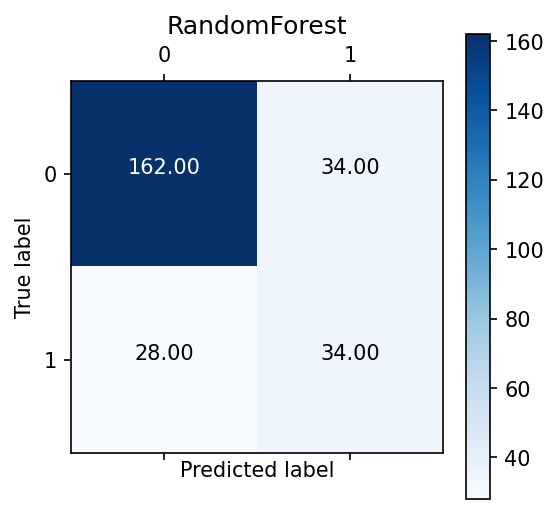

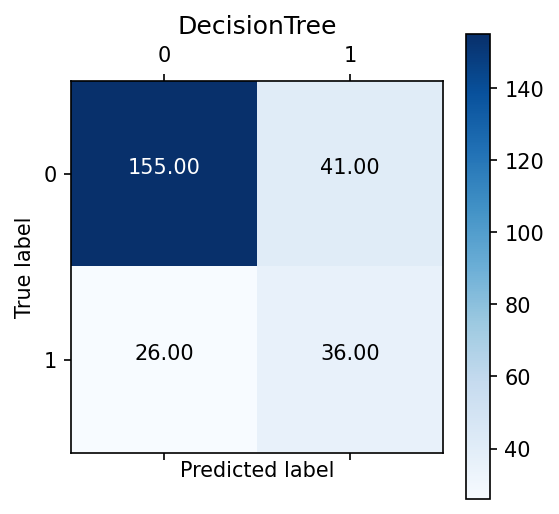

In [116]:
classes = ['Not AE', 'AE']
plt.rcParams['savefig.dpi'] = 150 #图片像素
plt.rcParams['figure.dpi'] = 150 #分辨率
for idx in range(2):
    cm = result['confusion matrix'][idx]
    plt.matshow(cm, cmap=plt.cm.Blues)
    plt.title(result['model'][idx])
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('ConfusionMatrix_NTU_8'+result['model'][idx]+'.png')
    plt.show()
    